In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 ## only use 50 % of the gpu
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [32]:
import numpy as np
import pandas as pd
from glob import glob
from tensorflow.keras.layers import (Input, Lambda, Dense, Flatten)
from tensorflow.keras.models import (Model, Sequential)
from tensorflow.keras.applications.mobilenet_v2 import (MobileNetV2, preprocess_input)
from tensorflow.keras.preprocessing.image import (ImageDataGenerator, load_img, array_to_img, img_to_array)
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [23]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'dataset/train'
valid_path = 'dataset/val'
test_path =  'dataset/test'

In [20]:

mobileNet = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [21]:
# useful for getting number of output classes
folders = glob('dataset/train/*')
print("total no of folders", len(folders))

total no of folders 100


###  Data Augmentation 

In [22]:
## Fine Tune The Layer 

print("Number of layers in the Mobile Net  model: ", len(mobileNet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 80

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobileNet.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the Mobile Net  model:  154


In [28]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#learning_rate reduce module
lr_reduce = ReduceLROnPlateau('val_loss', patience=4, 
                                              factor=0.5, min_lr=1e-6)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=4,
                              verbose=0, restore_best_weights=True)

In [29]:
history = model.fit(train_generator,
                         batch_size = 32,
                         epochs=70,
                         validation_data=validation_generator,
                         callbacks=[lr_reduce, early_stopper],
                         verbose=1, shuffle=True)

In [31]:
Model.compile(optimizer = adam(1e-5),  # Low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

NameError: name 'adam' is not defined

In [ ]:
model.summary()


In [11]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1200 images belonging to 100 classes.


Found 400 images belonging to 100 classes.


In [13]:
print("LIST OF THE CLASS NAME  ARE :-", list(training_set.class_indices.keys()))

LIST OF THE CLASS NAME  ARE :- ['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


In [14]:
validation_set

In [15]:
# fit the model
# Run the cell. It will take some time to execute

hist = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/10
38/38 [==============================] - 799s 17s/step - loss: 20.1138 - accuracy: 0.0617 - val_loss: 13.1552 - val_accuracy: 0.1475
Epoch 2/10
38/38 [==============================] - 624s 16s/step - loss: 10.4628 - accuracy: 0.2592 - val_loss: 11.6760 - val_accuracy: 0.2425
Epoch 3/10
38/38 [==============================] - 669s 18s/step - loss: 7.5465 - accuracy: 0.3892 - val_loss: 10.3703 - val_accuracy: 0.2800
Epoch 4/10
38/38 [==============================] - 507s 13s/step - loss: 6.5507 - accuracy: 0.4892 - val_loss: 13.1956 - val_accuracy: 0.2400
Epoch 5/10
38/38 [==============================] - 947s 25s/step - loss: 6.2721 - accuracy: 0.5075 - val_loss: 12.1816 - val_accuracy: 0.2800
Epoch 6/10
38/38 [==============================] - 512s 13s/step - loss: 5.6569 - accuracy: 0.5800 - val_loss: 12.4535 - val_accuracy: 0.2950
Epoch 7/10
38/38 [==============================] - 502s 13s/step - loss: 5.5039 - accuracy: 0.5858 - val_loss: 12.1307 - val_accuracy: 0.29

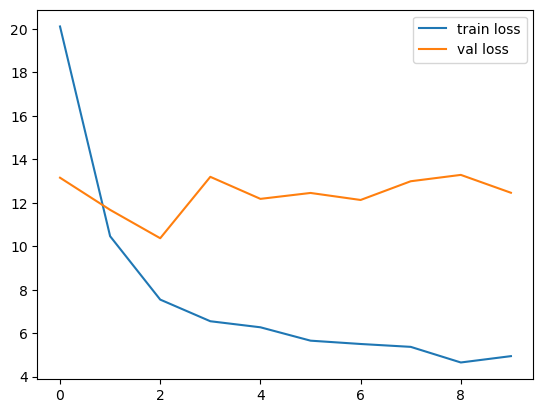

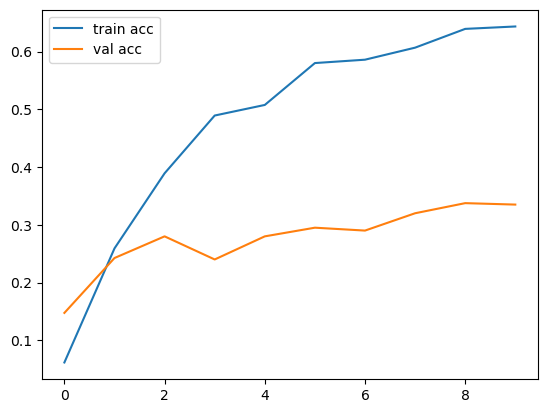

<Figure size 640x480 with 0 Axes>

In [17]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [20]:
y_pred = model.predict(validation_set)

13/13 [==============================] - 164s 9s/step


In [25]:
y_pred[0]

23

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [27]:
loaded_model=load_model('model_inception.h5')


In [30]:
img=image.load_img(r'E:\Project\Notebooks\dataset\test\1\image_1.png',target_size=(224,224))

x=image.img_to_array(img)
print(x.shape)

(224, 224, 3)


In [31]:
x=x/255

In [32]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [33]:
model.predict(img_data)

1/1 [==============================] - 46s 46s/step


array([[7.8945952e-03, 1.3321315e-06, 8.8256208e-08, 4.3862077e-08,
        1.7342404e-06, 1.6697378e-08, 4.5137238e-04, 2.6695414e-08,
        1.1770725e-08, 6.5810285e-03, 9.7047015e-10, 1.0830883e-12,
        1.5020149e-05, 1.5443648e-01, 2.5328088e-06, 1.1585558e-07,
        1.8477121e-09, 3.2366043e-07, 1.0153453e-05, 4.1616428e-08,
        1.6527505e-05, 3.8624351e-04, 4.8158846e-09, 4.5349609e-04,
        1.6144863e-03, 7.9313899e-08, 1.1017986e-03, 1.6830072e-08,
        1.3303853e-04, 3.3551812e-09, 7.2045741e-06, 8.5316632e-10,
        8.6374985e-07, 1.6286594e-03, 2.5701985e-02, 1.6111861e-01,
        2.6992045e-03, 1.6930332e-02, 1.4092545e-07, 2.5064626e-01,
        2.5780329e-05, 1.7155969e-04, 1.7456858e-05, 4.8073821e-07,
        4.7549922e-05, 4.6357732e-06, 4.1330568e-07, 3.5994200e-04,
        5.6666151e-05, 4.7049016e-06, 2.8883038e-05, 3.4408390e-07,
        9.1017336e-09, 1.5798130e-03, 1.0803336e-07, 2.0639160e-04,
        7.8161293e-08, 4.4706947e-05, 3.9050821e

In [34]:
a=np.argmax(model.predict(img_data), axis=1)
a

1/1 [==============================] - 1s 520ms/step


array([39], dtype=int64)